# Quantum Neural Networks (work in progress)

In [2]:
#Qiskit & qiskit_machine_learning
from qiskit import QuantumCircuit, execute
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.algorithms.optimizers import COBYLA, ADAM, SPSA
from qiskit.circuit import Parameter, ParameterVector
from qiskit.providers.aer import QasmSimulator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from matplotlib import rcParams
import itertools
import seaborn as sns
import math
from operator import add

import time
from IPython.display import clear_output

In [3]:
#Ignore all future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
rcParams["figure.figsize"] = 4, 4 

algorithm_globals.random_seed = 367

In [4]:
def SimpleQNN(numLayers, numFeatures):
    qc = QuantumCircuit(num_features)
    parameters = []
    
    for i in range(numLayers):
        for j in range(numFeatures):
            param = Parameter(f"θ{((i)*numFeatures) + (j)}")
            qc.ry(param, numFeatures-j-1)
            
        for k in range(numFeatures-1):
            qc.cx(numFeatures-k-1, numFeatures-k-2)
    
        if i < numLayers-1:
            qc.barrier()

    qc.measure_all()
    return qc

def QNN(feature_map, ansatz, shots, optimizer, callback):
    vqc = VQC(feature_map=feature_map,
         ansatz=ansatz,
         loss='cross_entropy',
         sampler=Sampler(options={"shots": shots}),
         optimizer=optimizer,
         callback=callback
         )
    
    return vqc

def TrainingCallback(weights, obj_func_eval):
    
    #Clear output
    clear_output(wait=True)

    #Append values
    objective_func_vals.append(obj_func_eval)

    #Annotations
    plt.title("Cross-entropy loss against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Cross-entropy loss")

    #Display
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
    
def selectColumns(train, val, test, columns):
    train = train.iloc[:, columns]
    val = val.iloc[:, columns]
    test = test.iloc[:, columns]
    
    return train, val, test

def simpleRxEncoder(n_features):
    qc = QuantumCircuit(num_features)

    param = ParameterVector('Feature',num_features) 

    for i in range(num_features):
        qc.rx(param[i], i)

    return qc

def plot_confusion_matrix(cm, size):
    """
    Plots the confusion matrix
    Input:
    cm - a sklearn.metrics confusion_matrix
    """
    
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.grid(False)


    # Threshold to decide the color of the numbers in the matrix
    # White for dark background, black for light background
    threshold = cm.max() / 2.

    # Iterate over the confusion matrix
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black")

    plt.xticks([i for i in range(size)], range(size))
    plt.yticks([i for i in range(size)], range(size))

    plt.title('Confusion matrix', fontsize=18)
    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label', fontsize=18)
    plt.show()



In [5]:
# Load dataset
data = datasets.load_iris()

# Create DataFrame
iris = pd.DataFrame(data=np.c_[data['data'], data['target']],
                   columns=data['feature_names'] + ['label'])

iris['label'] = iris['label'].astype('int32')
iris['label'] = iris['label'].astype('category')

iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [6]:
data['feature_names']

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [7]:
data['target_names']

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [8]:
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   sepal length (cm)  150 non-null    float64 
 1   sepal width (cm)   150 non-null    float64 
 2   petal length (cm)  150 non-null    float64 
 3   petal width (cm)   150 non-null    float64 
 4   label              150 non-null    category
dtypes: category(1), float64(4)
memory usage: 5.1 KB


## Preprocess

### Feature Engineering

Adding the square and log of each of the variables to the data set. This will be used to train different models.

In [9]:
# Split the dataframe into predictors and response/target variable
predictors = iris.iloc[:, :-1]
target = iris.iloc[:, -1]

In [10]:
# Square the predictors
predictors["sepal length_2"] = predictors["sepal length (cm)"]**2
predictors["sepal width_2"] = predictors["sepal width (cm)"]**2
predictors["petal length_2"] = predictors["petal length (cm)"]**2
predictors["petal width_2"] = predictors["petal width (cm)"]**2

# Take log of the predictors
predictors["sepal length_log"] = np.log(predictors["sepal length (cm)"])
predictors["sepal width_log"] = np.log(predictors["sepal width (cm)"])
predictors["petal length_log"] = np.log(predictors["petal length (cm)"])
predictors["petal width_log"] = np.log(predictors["petal width (cm)"])

# length/width for sepal and petal
predictors["sepal WL_ratio"] = predictors["sepal length (cm)"]/predictors["sepal width (cm)"]
predictors["petal WL_ratio"] = predictors["petal length (cm)"]/predictors["petal width (cm)"]

In [11]:
predictors.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),sepal length_2,sepal width_2,petal length_2,petal width_2,sepal length_log,sepal width_log,petal length_log,petal width_log,sepal WL_ratio,petal WL_ratio
0,5.1,3.5,1.4,0.2,26.01,12.25,1.96,0.04,1.629241,1.252763,0.336472,-1.609438,1.457143,7.0
1,4.9,3.0,1.4,0.2,24.01,9.00,1.96,0.04,1.589235,1.098612,0.336472,-1.609438,1.633333,7.0
2,4.7,3.2,1.3,0.2,22.09,10.24,1.69,0.04,1.547563,1.163151,0.262364,-1.609438,1.468750,6.5
3,4.6,3.1,1.5,0.2,21.16,9.61,2.25,0.04,1.526056,1.131402,0.405465,-1.609438,1.483871,7.5
4,5.0,3.6,1.4,0.2,25.00,12.96,1.96,0.04,1.609438,1.280934,0.336472,-1.609438,1.388889,7.0


## Split into Train-Validate-Test 

In [12]:
# Split the data into training-validation-test sets with a 70-15-15 split
# Datapoints are shuffled
X_train, X_val_test, Y_train, Y_val_test = train_test_split(predictors, target, test_size=.3, shuffle=True, random_state=367)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_test, Y_val_test, test_size=.5, shuffle=False)

In [13]:
X_train.shape, Y_train.shape

((105, 14), (105,))

In [14]:
X_val.shape, Y_val.shape

((22, 14), (22,))

In [15]:
X_test.shape, Y_test.shape

((23, 14), (23,))

## Data Exploration

In [16]:
X_train.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),sepal length_2,sepal width_2,petal length_2,petal width_2,sepal length_log,sepal width_log,petal length_log,petal width_log,sepal WL_ratio,petal WL_ratio
count,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000
mean,5.805714,3.086667,3.634286,1.160000,34.445905,9.711905,16.369714,1.930667,1.748023,1.117340,1.132995,-0.223800,1.920170,4.382323
std,0.864117,0.431470,1.786640,0.768565,10.349430,2.725752,12.695446,1.816617,0.147466,0.141005,0.602282,0.999241,0.396116,2.643591
min,4.400000,2.000000,1.000000,0.100000,19.360000,4.000000,1.000000,0.010000,1.481605,0.693147,0.000000,-2.302585,1.268293,2.125000
25%,5.000000,2.800000,1.500000,0.300000,25.000000,7.840000,2.250000,0.090000,1.609438,1.029619,0.405465,-1.203973,1.515152,2.800000
50%,5.700000,3.000000,4.200000,1.300000,32.490000,9.000000,17.640000,1.690000,1.740466,1.098612,1.435085,0.262364,2.000000,3.307692
75%,6.400000,3.400000,5.100000,1.800000,40.960000,11.560000,26.010000,3.240000,1.856298,1.223775,1.629241,0.587787,2.200000,4.666667
max,7.900000,4.400000,6.900000,2.400000,62.410000,19.360000,47.610000,5.760000,2.066863,1.481605,1.931521,0.875469,2.961538,15.000000


The iris data set have 150 datapoints and has no missing values. There are four predictors: sepal length, sepal width, petal length and petal width. The response variable has three classes and has the following encoding: 0 = setosa, 1 = versicolor and 2 = virginicia.

All the predictors are measured in centimeters. <br>
Sepal length has a min value of 4.4 and a max value of 7.9 <br>
Sepal width has a min value of 2.0 and a max value of 4.4 <br>
Petal length has a min value of 1.0 and a max value of 6.9 <br>
Petal width has a min value of 0.1 and a max value of 2.4 <br>

In [17]:
# Dataframe used for plotting, we want to do data exploration
# on training data only
training_data = X_train.assign(label=Y_train)
training_data['label'] = training_data['label'].cat.rename_categories({0: 'setosa', 1: 'versicolor', 2: 'virginica'})

Text(0.5, 1.0, 'Petal Width vs Petal Height')

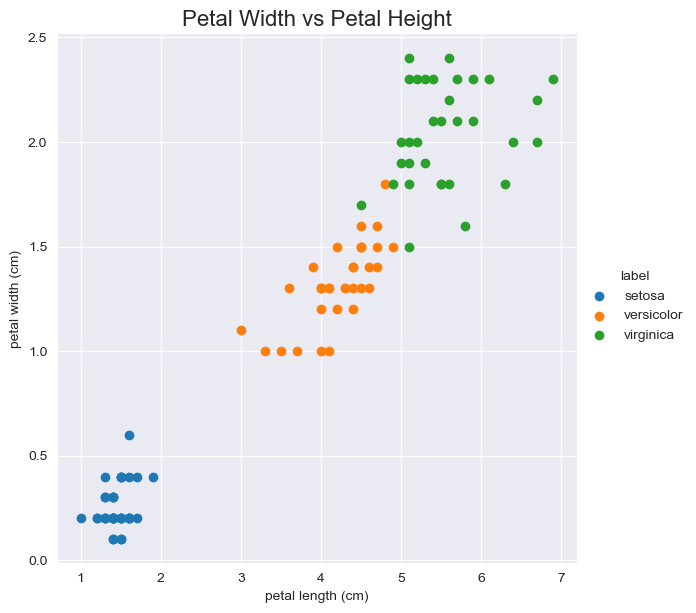

In [18]:
sns.set_style("darkgrid")

sns.FacetGrid(training_data, hue ="label", 
              height = 6).map(plt.scatter, 
                              "petal length (cm)", 
                              "petal width (cm)").add_legend()

plt.title("Petal Width vs Petal Height", fontsize=16)

Text(0.5, 1.0, 'Sepal Width vs Sepal Height')

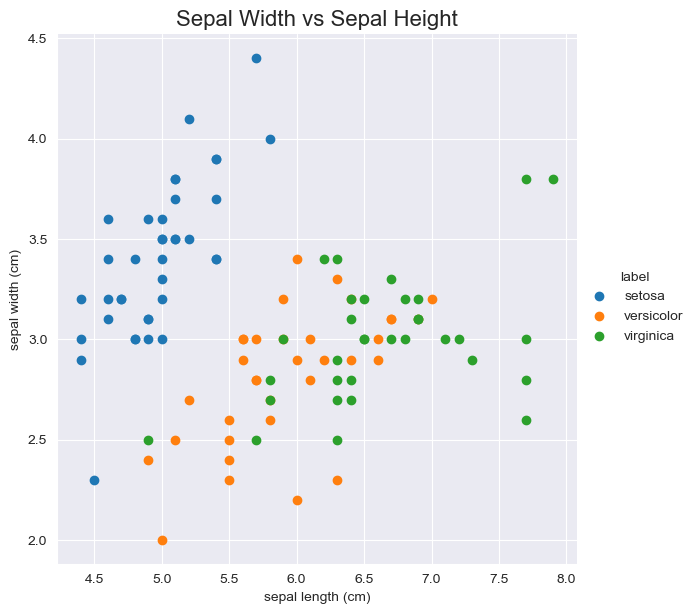

In [19]:
sns.FacetGrid(training_data, hue ="label", 
              height = 6).map(plt.scatter, 
                              "sepal length (cm)", 
                              "sepal width (cm)").add_legend()

plt.title("Sepal Width vs Sepal Height", fontsize=16)

Text(0.5, 1.0, 'Petal Ratio vs Sepal Ratio')

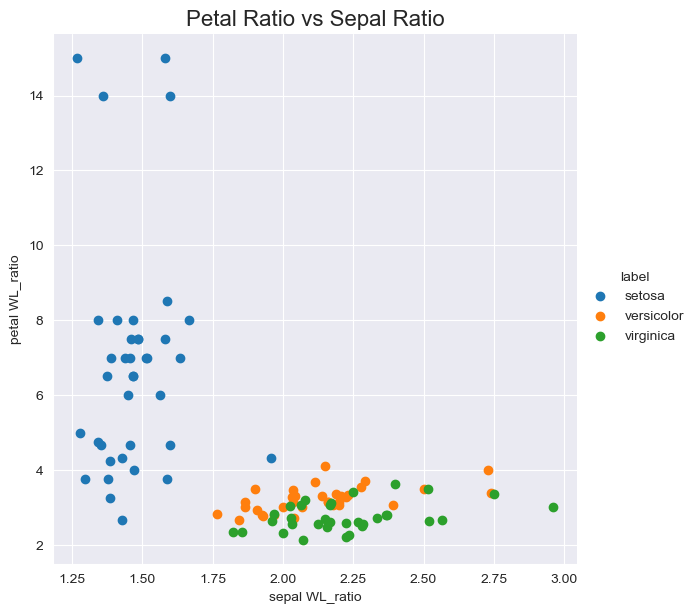

In [20]:
sns.FacetGrid(training_data, hue ="label", 
              height = 6).map(plt.scatter, 
                              "sepal WL_ratio", 
                              "petal WL_ratio").add_legend()

plt.title("Petal Ratio vs Sepal Ratio", fontsize=16)

### Normalize with MinMaxScaler

In [21]:
# Normalize between -pi and pi
scaler = MinMaxScaler(feature_range=(-np.pi, np.pi))
predictors = pd.DataFrame(scaler.fit_transform(predictors), columns=predictors.columns)

In [22]:
predictors.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),sepal length_2,sepal width_2,petal length_2,petal width_2,sepal length_log,sepal width_log,petal length_log,petal width_log,sepal WL_ratio,petal WL_ratio
count,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000
mean,-0.447968,-0.373500,-0.204470,-0.263545,-0.804616,-0.877028,-0.955343,-1.122180,-0.075884,0.159884,0.680774,1.016640,-0.598299,-2.075037
std,1.445248,1.141095,1.879948,1.995534,1.419399,1.120265,1.702168,1.842875,1.458480,1.139874,1.919659,1.918797,1.486076,1.214984
min,-3.141593,-3.141593,-3.141593,-3.141593,-3.141593,-3.141593,-3.141593,-3.141593,-3.141593,-3.141593,-3.141593,-3.141593,-3.141593,-3.141593
25%,-1.745329,-1.047198,-2.502625,-2.617994,-2.065783,-1.570796,-2.931299,-3.061039,-1.379035,-0.460259,-1.612684,-0.997122,-2.110398,-2.811021
50%,-0.523599,-0.523599,0.425979,0.000000,-0.974237,-1.096285,-0.725242,-1.449966,-0.050420,0.089543,1.640633,1.865140,-0.306595,-2.568176
75%,0.523599,0.261799,1.224689,1.308997,0.072960,-0.323159,0.229840,0.110761,0.966463,0.849066,2.158281,2.500359,0.408162,-1.901223
max,3.141593,3.141593,3.141593,3.141593,3.141593,3.141593,3.141593,3.141593,3.141593,3.141593,3.141593,3.141593,3.141593,3.141593


## Select loss function

In the iris data set we need to use a multi-class classification loss function since we have three classes. There are a number of different loss functions we can use such as Categorical Cross-Entropy Loss, Kullback Leibler Divergence Loss and Hinge Loss. Hinge loss is mostly used for Support Vector Machines, so we did not consider this here. 

Categorical Cross-Entropy Loss, also called Log Loss, is the most common loss function used in neural network classifiers and measures the dissimilarity between the predictions and the true labels. Cross-Entropy Loss is given by:

$ L({y}_{i}, \hat{y}_{i}) = -\Sigma {y}_{i} \log \hat{y}_{i} $, where <br><br>
$ {y}_{i} $ is the true probability distribution and <br>
$ \hat{y}_{i} $ is the predicted probability distribution of the model <br>

In neural networks we use a softmax activation function on the output of the model to get class probabilities. If the predicted probabilities are close to the true labels, we get a loss close to zero and if all the predictions are wrong, we get a loss of one. We use gradient descent to update the weights of the model. Cross-Entropy gives us a clear and intuitive way to validate the performance of our models.

Kullback-Leibler Divergence Loss measures how a probability distribution differs from another probability distribution. 

$ D_{KL}(g||f)=H(g,f)-H(g) = -(\Sigma g(x) \log f(x) - \Sigma g(x) \log g(x) $ <br><br>

Kullback-Leibler measures how much information is lost when we use f(x) to approximate g(x). Here g(x) is the true distribution and f(x) are the predicted distribution. For neural networks in machine learning we can write this as: <br>
$  D_{KL}({y}_{i}||\hat{y}_{i}) = -(\Sigma y_{i} \log \hat{y}_{i} - \Sigma y_{i}\log y_{i}) $ , where<br><br>
$ {y}_{i} $ is the true labels and <br>
$ \hat{y}_{i} $ is the predictions <br><br>
Since the last part of the equation only uses the original training data and not the predictions of the model, it does not depend on the weights of the model. Therefor we end up with the same optimal weights in Kullback-Leibler and Cross-Entropy. Since both loss functions give the same weights, we chose to use Cross-Entropy as it is a little easier to work with. Cross-Entropy is also the only one of the mentioned loss functions that is implemented in the qiskit VQC() method.

## Choose different types of QNN

In [23]:
# Start with the original four features
X_train_base, X_val_base, X_test_base = selectColumns(X_train, X_val, X_test, [0, 1, 2, 3])
num_features = X_train_base.shape[1]

In [24]:
# Look at the shape of the training data
X_train_base.shape

(105, 4)

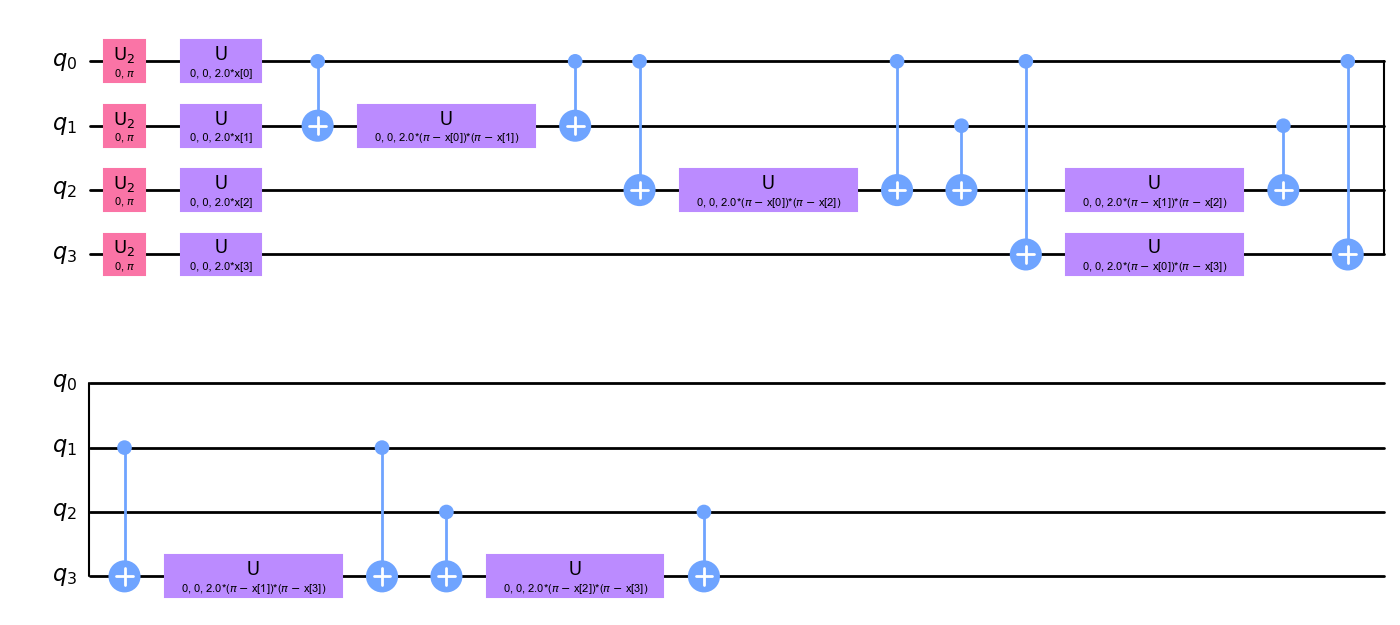

In [25]:
#Use Qiskit's built-in feature mapper:
feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1, entanglement='full')
feature_map.decompose().decompose().draw(output="mpl", fold=20)

### Model 1

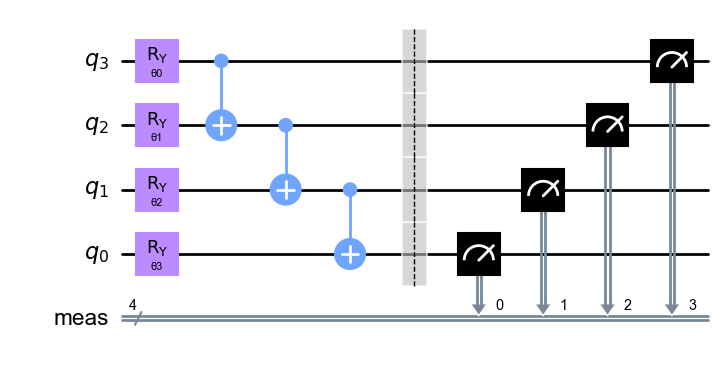

In [26]:
# Simple QNN with one layer
ansatz = SimpleQNN(1, num_features)
ansatz.draw(output='mpl', fold=20, reverse_bits=True)

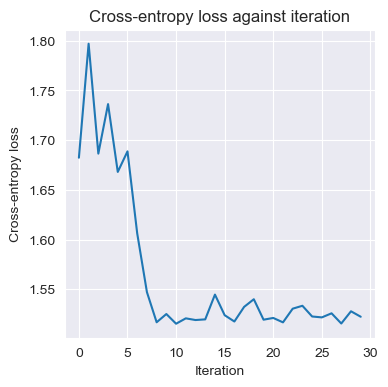

Validation Accuracy of the Model:     0.36


In [27]:
optimizer = COBYLA(maxiter=30)

QNN1 = QNN(feature_map, ansatz, 1000, optimizer, TrainingCallback)

objective_func_vals = []

# Fit model
QNN1.fit(X_train_base.to_numpy(), Y_train.to_numpy())

validation_score1 = QNN1.score(X_val_base, Y_val)
print(f"Validation Accuracy of the Model:     {validation_score1:.2f}")

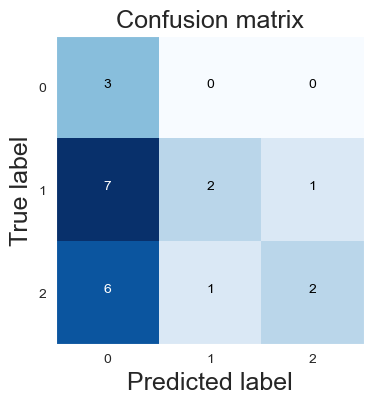

In [28]:
pred1 = QNN1.predict(X_val_base)
cm1 = confusion_matrix(Y_val, pred1, labels=np.unique(Y_val))
plot_confusion_matrix(cm1, 3)

### Model 2

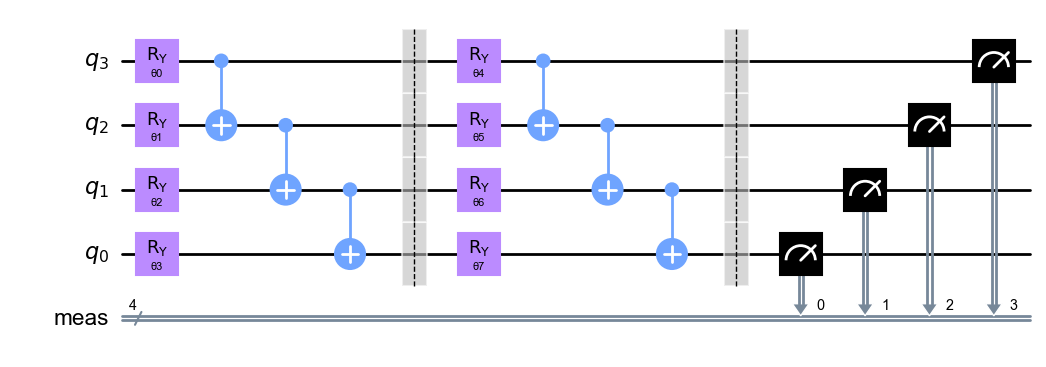

In [29]:
# Simple QNN with two layer
ansatz = SimpleQNN(2, num_features)
ansatz.draw(output='mpl', fold=20, reverse_bits=True)

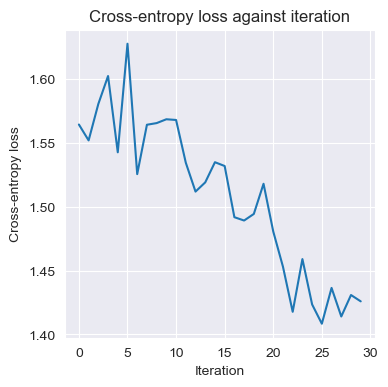

Validation Accuracy of the Model:     0.59


In [30]:
optimizer = COBYLA(maxiter=30)

QNN2 = QNN(feature_map, ansatz, 1000, optimizer, TrainingCallback)

objective_func_vals = []

# Fit model
QNN2.fit(X_train_base.to_numpy(), Y_train.to_numpy())

validation_score2 = QNN2.score(X_val_base, Y_val)
print(f"Validation Accuracy of the Model:     {validation_score2:.2f}")

In [31]:
pred2 = QNN2.predict(X_val_base)
cm2 = confusion_matrix(Y_val, pred2, labels=np.unique(Y_val))
cm2

array([[2, 0, 1],
       [3, 2, 5],
       [0, 2, 7]], dtype=int64)

### Model 3

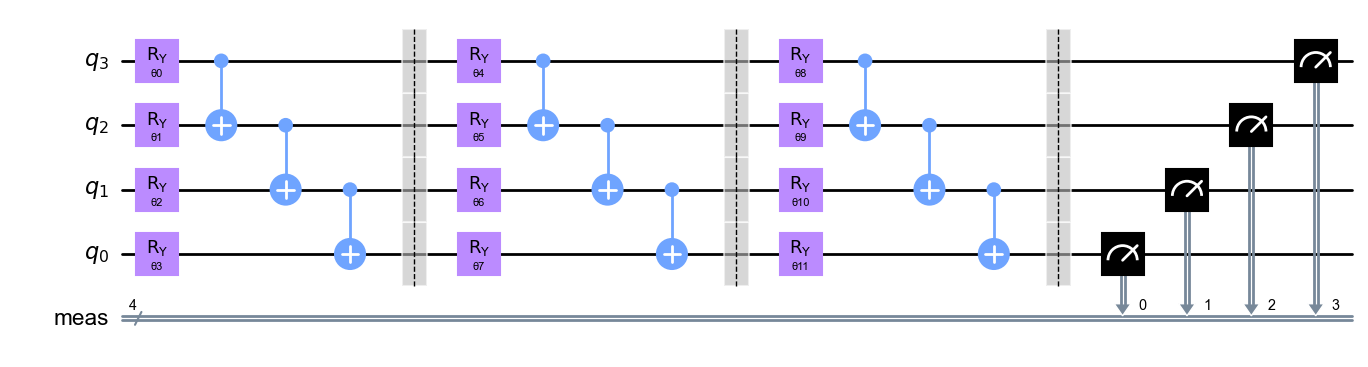

In [32]:
# Simple QNN with three layers
ansatz = SimpleQNN(3, num_features)
ansatz.draw(output='mpl', fold=20, reverse_bits=True)

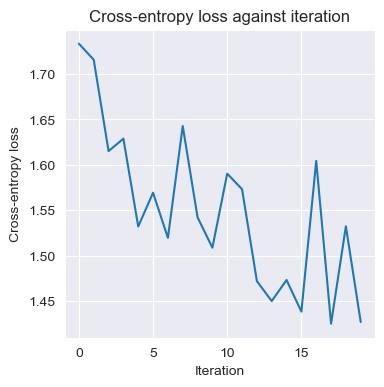

Validation Accuracy of the Model:     0.45


In [33]:
optimizer = COBYLA(maxiter=20)

QNN3 = QNN(feature_map, ansatz, 1000, optimizer, TrainingCallback)

objective_func_vals = []

# Fit model
QNN3.fit(X_train_base.to_numpy(), Y_train.to_numpy())

validation_score3 = QNN3.score(X_val_base, Y_val)
print(f"Validation Accuracy of the Model:     {validation_score3:.2f}")

In [34]:
pred3 = QNN3.predict(X_val_base)
cm3 = confusion_matrix(Y_val, pred3, labels=np.unique(Y_val))
cm3

array([[2, 0, 1],
       [6, 3, 1],
       [0, 2, 7]], dtype=int64)

### Model 4 - simple feature encoder

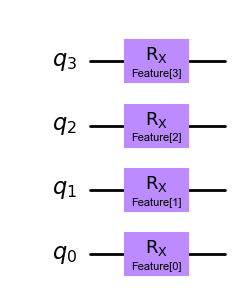

In [35]:
feature_map = simpleRxEncoder(num_features)
feature_map.draw(output='mpl', fold=20, reverse_bits=True)

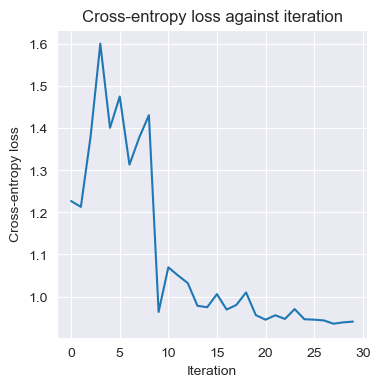

Validation Accuracy of the Model:     0.77


In [36]:
# Simple QNN with two layers
ansatz = SimpleQNN(2, num_features)

optimizer = COBYLA(maxiter=30)

QNN4 = QNN(feature_map, ansatz, 1000, optimizer, TrainingCallback)

objective_func_vals = []

# Fit model
QNN4.fit(X_train_base.to_numpy(), Y_train.to_numpy())

validation_score4 = QNN4.score(X_val_base, Y_val)
print(f"Validation Accuracy of the Model:     {validation_score4:.2f}")

In [37]:
pred4 = QNN4.predict(X_val_base)
cm4 = confusion_matrix(Y_val, pred4, labels=np.unique(Y_val))
cm4

array([[1, 0, 2],
       [0, 9, 1],
       [0, 2, 7]], dtype=int64)

### Model 5

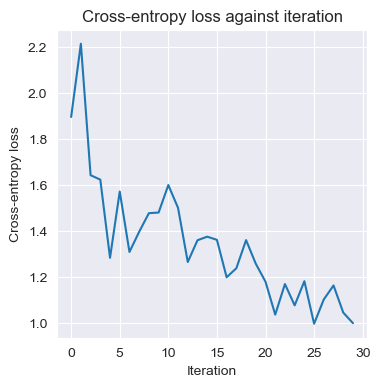

Validation Accuracy of the Model:     0.64


In [38]:
# Simple QNN with five layer
ansatz = SimpleQNN(5, num_features)

optimizer = COBYLA(maxiter=30)

QNN5 = QNN(feature_map, ansatz, 1000, optimizer, TrainingCallback)

objective_func_vals = []

# Fit model
QNN5.fit(X_train_base.to_numpy(), Y_train.to_numpy())

validation_score5 = QNN5.score(X_val_base, Y_val)
print(f"Validation Accuracy of the Model:     {validation_score5:.2f}")

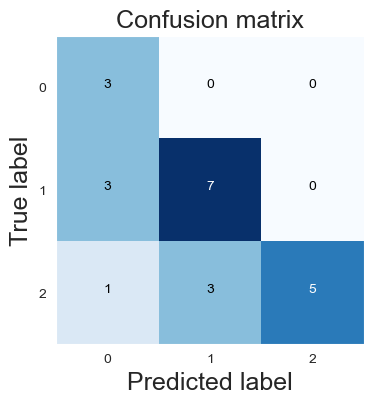

In [39]:
pred5 = QNN5.predict(X_val_base)
cm5 = confusion_matrix(Y_val, pred5, labels=np.unique(Y_val))
plot_confusion_matrix(cm5, 3)

### Model 6 - With squared predictors

The simple encoder seems to perform better then ZZFeatureMap(), so we will continue using that. The next models will be trained using the four original features and the square of each feature, for a total of eight features.

In [40]:
X_train_sq, X_val_sq, X_test_sq = selectColumns(X_train, X_val, X_test, [0, 1, 2, 3, 4, 5, 6, 7])
num_features = X_train_sq.shape[1]
X_train_sq.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),sepal length_2,sepal width_2,petal length_2,petal width_2
6,4.6,3.4,1.4,0.3,21.16,11.56,1.96,0.09
148,6.2,3.4,5.4,2.3,38.44,11.56,29.16,5.29
86,6.7,3.1,4.7,1.5,44.89,9.61,22.09,2.25
147,6.5,3.0,5.2,2.0,42.25,9.00,27.04,4.00
113,5.7,2.5,5.0,2.0,32.49,6.25,25.00,4.00


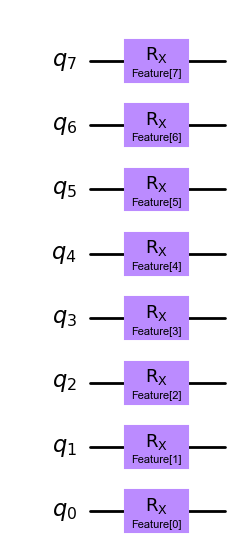

In [41]:
# Simple featuremap
feature_map = simpleRxEncoder(num_features)
feature_map.draw(output='mpl', fold=20, reverse_bits=True)

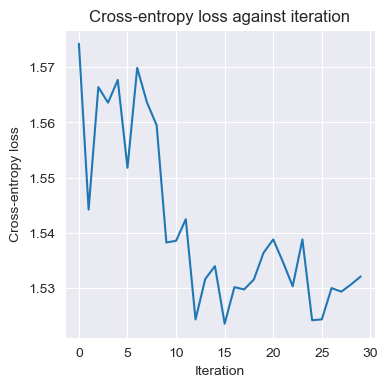

Validation Accuracy of the Model:     0.36


In [42]:
# Simple QNN with one layer
ansatz = SimpleQNN(1, num_features)

optimizer = COBYLA(maxiter=30)

QNN6 = QNN(feature_map, ansatz, 1000, optimizer, TrainingCallback)

objective_func_vals = []

# Fit model
QNN6.fit(X_train_sq.to_numpy(), Y_train.to_numpy())

validation_score6 = QNN6.score(X_val_sq, Y_val)
print(f"Validation Accuracy of the Model:     {validation_score6:.2f}")

In [43]:
pred6 = QNN6.predict(X_val_sq)
cm6 = confusion_matrix(Y_val, pred6, labels=np.unique(Y_val))
cm6

array([[3, 0, 0],
       [4, 3, 3],
       [4, 3, 2]], dtype=int64)

### Model 7

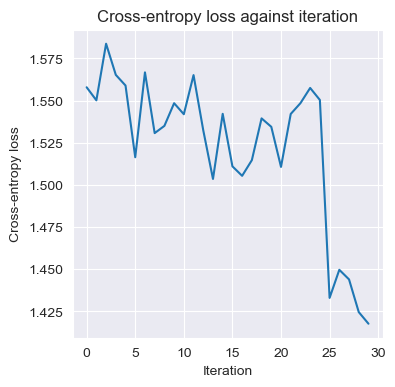

Validation Accuracy of the Model:     0.45


In [44]:
# Simple QNN with three layers
ansatz = SimpleQNN(3, num_features)

optimizer = COBYLA(maxiter=30)

QNN7 = QNN(feature_map, ansatz, 1000, optimizer, TrainingCallback)

objective_func_vals = []

# Fit model
QNN7.fit(X_train_sq.to_numpy(), Y_train.to_numpy())

validation_score7 = QNN7.score(X_val_sq, Y_val)
print(f"Validation Accuracy of the Model:     {validation_score7:.2f}")

In [45]:
pred7 = QNN7.predict(X_val_sq)
cm7 = confusion_matrix(Y_val, pred7, labels=np.unique(Y_val))
cm7

array([[2, 0, 1],
       [1, 3, 6],
       [3, 2, 4]], dtype=int64)

### Model 8

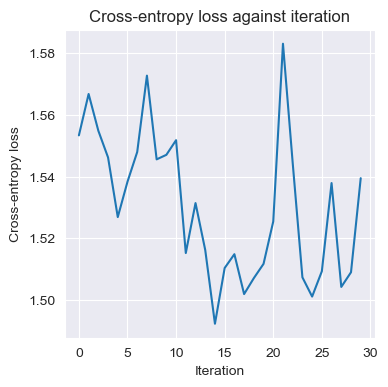

Validation Accuracy of the Model:     0.41


In [46]:
# Simple QNN with five layer
ansatz = SimpleQNN(5, num_features)

optimizer = COBYLA(maxiter=30)

QNN8 = QNN(feature_map, ansatz, 1000, optimizer, TrainingCallback)

objective_func_vals = []

# Fit model
QNN8.fit(X_train_sq.to_numpy(), Y_train.to_numpy())

validation_score8 = QNN8.score(X_val_sq, Y_val)
print(f"Validation Accuracy of the Model:     {validation_score8:.2f}")

In [47]:
pred8 = QNN8.predict(X_val_sq)
cm8 = confusion_matrix(Y_val, pred8, labels=np.unique(Y_val))
cm8

array([[1, 2, 0],
       [4, 4, 2],
       [4, 1, 4]], dtype=int64)

### Model 9 - With the logarithm of the predictors

Next we will train models using the four original features and the logarithm of the features.

In [48]:
X_train_log, X_val_log, X_test_log = selectColumns(X_train, X_val, X_test, [0, 1, 2, 3, 8, 9, 10, 11])
num_features = X_train_log.shape[1]
X_train_log.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),sepal length_log,sepal width_log,petal length_log,petal width_log
6,4.6,3.4,1.4,0.3,1.526056,1.223775,0.336472,-1.203973
148,6.2,3.4,5.4,2.3,1.824549,1.223775,1.686399,0.832909
86,6.7,3.1,4.7,1.5,1.902108,1.131402,1.547563,0.405465
147,6.5,3.0,5.2,2.0,1.871802,1.098612,1.648659,0.693147
113,5.7,2.5,5.0,2.0,1.740466,0.916291,1.609438,0.693147


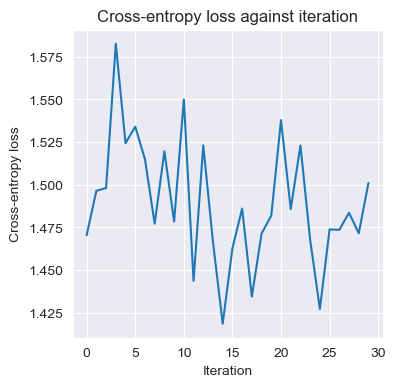

Validation Accuracy of the Model:     0.55


In [49]:
# Simple QNN with five layers
ansatz = SimpleQNN(5, num_features)

optimizer = COBYLA(maxiter=30)

QNN9 = QNN(feature_map, ansatz, 1000, optimizer, TrainingCallback)

objective_func_vals = []

# Fit model
QNN9.fit(X_train_log.to_numpy(), Y_train.to_numpy())

validation_score9 = QNN9.score(X_val_log, Y_val)
print(f"Validation Accuracy of the Model:     {validation_score9:.2f}")

In [50]:
pred9 = QNN9.predict(X_val_log)
cm9 = confusion_matrix(Y_val, pred9, labels=np.unique(Y_val))
cm9

array([[3, 0, 0],
       [3, 1, 6],
       [2, 1, 6]], dtype=int64)

### Model 10 - With the length/width ratio of sepal and petal

We created two new features by taking the sepal/petal height divided by the width to get a height/width ratio. Here we have trained some models using those features.

In [51]:
X_train_ratio, X_val_ratio, X_test_ratio = selectColumns(X_train, X_val, X_test, [0, 1, 2, 3, 12, 13])
num_features = X_train_ratio.shape[1]
X_train_ratio.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),sepal WL_ratio,petal WL_ratio
6,4.6,3.4,1.4,0.3,1.352941,4.666667
148,6.2,3.4,5.4,2.3,1.823529,2.347826
86,6.7,3.1,4.7,1.5,2.161290,3.133333
147,6.5,3.0,5.2,2.0,2.166667,2.600000
113,5.7,2.5,5.0,2.0,2.280000,2.500000


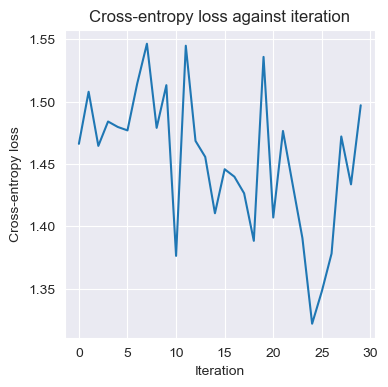

Validation Accuracy of the Model:     0.77


In [52]:
feature_map = simpleRxEncoder(num_features)

# Simple QNN with five layer
ansatz = SimpleQNN(5, num_features)

optimizer = COBYLA(maxiter=30)

QNN10 = QNN(feature_map, ansatz, 1000, optimizer, TrainingCallback)

objective_func_vals = []

# Fit model
QNN10.fit(X_train_ratio.to_numpy(), Y_train.to_numpy())

validation_score10 = QNN10.score(X_val_ratio, Y_val)
print(f"Validation Accuracy of the Model:     {validation_score10:.2f}")

In [53]:
pred10 = QNN10.predict(X_val_ratio)
cm10 = confusion_matrix(Y_val, pred10, labels=np.unique(Y_val))
cm10

array([[2, 0, 1],
       [0, 6, 4],
       [0, 1, 8]], dtype=int64)

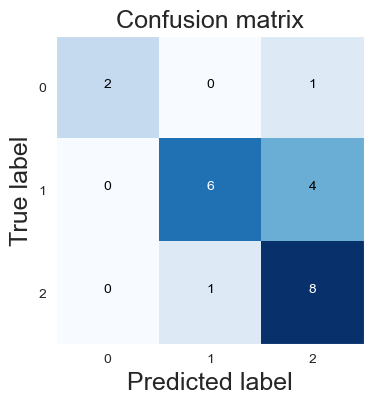

In [54]:
plot_confusion_matrix(cm10, 3)

### Model 11 - Using only the ratio features

In [55]:
X_train_ratio2, X_val_ratio2, X_test_ratio2 = selectColumns(X_train, X_val, X_test, [12, 13])
num_features = X_train_ratio2.shape[1]
X_train_ratio2.head()

,sepal WL_ratio,petal WL_ratio
6,1.352941,4.666667
148,1.823529,2.347826
86,2.161290,3.133333
147,2.166667,2.600000
113,2.280000,2.500000


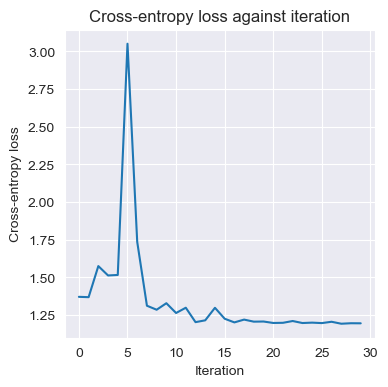

Validation Accuracy of the Model:     0.41


In [56]:
feature_map = simpleRxEncoder(num_features)

# Simple QNN with three layer
ansatz = SimpleQNN(3, num_features)

optimizer = COBYLA(maxiter=30)

QNN11 = QNN(feature_map, ansatz, 1000, optimizer, TrainingCallback)

objective_func_vals = []

# Fit model
QNN11.fit(X_train_ratio2.to_numpy(), Y_train.to_numpy())

validation_score11 = QNN11.score(X_val_ratio2, Y_val)
print(f"Validation Accuracy of the Model:     {validation_score11:.2f}")

In [57]:
pred11 = QNN11.predict(X_val_ratio2)
cm11 = confusion_matrix(Y_val, pred11, labels=np.unique(Y_val))
cm11

array([[3, 0, 0],
       [1, 7, 2],
       [1, 5, 3]], dtype=int64)

### Model 12 - Full data set (slow)

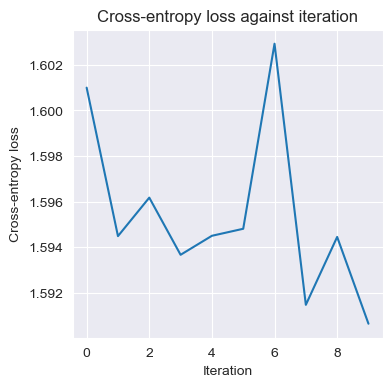

Validation Accuracy of the Model:     0.23


In [58]:
num_features = X_train.shape[1]
feature_map = simpleRxEncoder(num_features)

# Simple QNN with five layers
ansatz = SimpleQNN(5, num_features)

optimizer = COBYLA(maxiter=10)

QNN12 = QNN(feature_map, ansatz, 1000, optimizer, TrainingCallback)

objective_func_vals = []

# Fit model
QNN12.fit(X_train.to_numpy(), Y_train.to_numpy())

validation_score12 = QNN12.score(X_val, Y_val)
print(f"Validation Accuracy of the Model:     {validation_score12:.2f}")

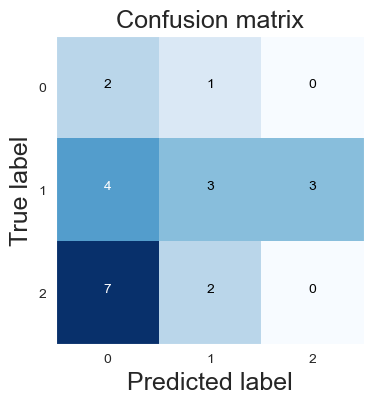

In [59]:
pred12 = QNN12.predict(X_val)
cm12 = confusion_matrix(Y_val, pred12, labels=np.unique(Y_val))
plot_confusion_matrix(cm12, 3)

### Model 13

In [60]:
X_train_petal, X_val_petal, X_test_petal = selectColumns(X_train, X_val, X_test, [2, 3])

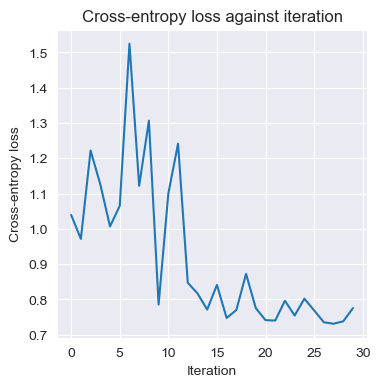

Validation Accuracy of the Model:     0.64


In [61]:
num_features = X_train_petal.shape[1]
feature_map = simpleRxEncoder(num_features)

# Simple QNN with five layers
ansatz = SimpleQNN(5, num_features)

optimizer = COBYLA(maxiter=30)

QNN13 = QNN(feature_map, ansatz, 1000, optimizer, TrainingCallback)

objective_func_vals = []

# Fit model
QNN13.fit(X_train_petal.to_numpy(), Y_train.to_numpy())

validation_score13 = QNN13.score(X_val_petal, Y_val)
print(f"Validation Accuracy of the Model:     {validation_score13:.2f}")

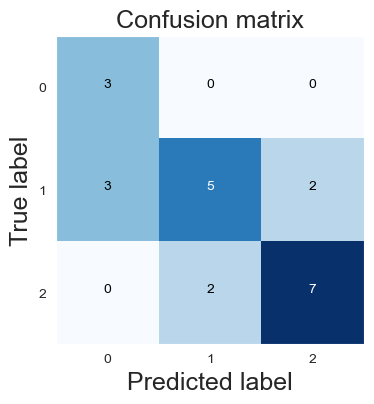

In [62]:
pred13 = QNN13.predict(X_val_petal)
cm13 = confusion_matrix(Y_val, pred13, labels=np.unique(Y_val))
plot_confusion_matrix(cm13, 3)

**TODO**

- Try different circuits
- Build my own model from scratch with gradient descent
- Test best model on the test data to get an unbiased estimate of how well the model generalizes